# Import packages and load data

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from matplotlib import rc
from matplotlib import cm
from matplotlib import rc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes  
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)  
import shap
xscaler = MinMaxScaler()

In [2]:
file_path = '../input_data/pspeo_master.xlsx'
model_output = 'fwhm'
# import data frame for pre-processing
df = pd.read_excel(file_path)
df.head()

,sample,solv_ratio,add_type,swell_ratio,gisaxs_domain,gisaxs_fwhm,afm_domain,afm_grain
0,I_A_AC,80/20,Chloronaphthalene,1.00,31.302630,0.003697,33.737303,0.0048
1,I_A025,80/20,Chloronaphthalene,1.25,33.805848,0.003136,35.151690,0.0047
2,I_A050,80/20,Chloronaphthalene,1.50,34.176062,0.002970,35.397797,0.0534
3,I_A075,80/20,Chloronaphthalene,1.75,34.383751,0.003451,34.603726,0.0425
4,I_A_100,80/20,Chloronaphthalene,2.00,31.674148,0.005122,33.786210,0.0244


# Data pre-processing

In [3]:
# Assign input variables and target variable, eliminating static valuesp
inputs = df.loc[:, ['solv_ratio', 'swell_ratio', 'add_type']]
target = df['gisaxs_fwhm']

# Define mapping for solv_ratio
type_mapping = {100: 1.0, '90/10': 0.9, '80/20': 0.8, '70/30': 0.7, '60/40': 0.6, '50/50': 0.5}
inputs['solv_ratio'] = inputs['solv_ratio'].replace(type_mapping)

# Encode categorical input 'add_type'
le_addType = LabelEncoder()
inputs['add_type'] = le_addType.fit_transform(inputs['add_type'])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(inputs, target, test_size=0.2, random_state=10)

# Scale the x data for better fitting
xscaler.fit(X_train)
X_train = xscaler.transform(X_train)
X_test = xscaler.transform(X_test)

# Grid-Search

In [4]:
from joblib import dump, load
# Convert cv_results_ to DataFrame

# Save the trained model
best = load(f'raw_models/{model_output}.joblib')

In [5]:
train_r2 = best.score(X_train, y_train)
test_r2 = best.score(X_test, y_test)

print(f'Training r2: {train_r2}')
print(f'Testing r2: {test_r2}')

rfr_train = best.predict(X_train)
rfr_test = best.predict(X_test)

# Define the output path for figures
output_path = f'final_figs/{model_output}/'

Training r2: 0.6988559361091194
Testing r2: 0.750070739244252


# Visualize the results

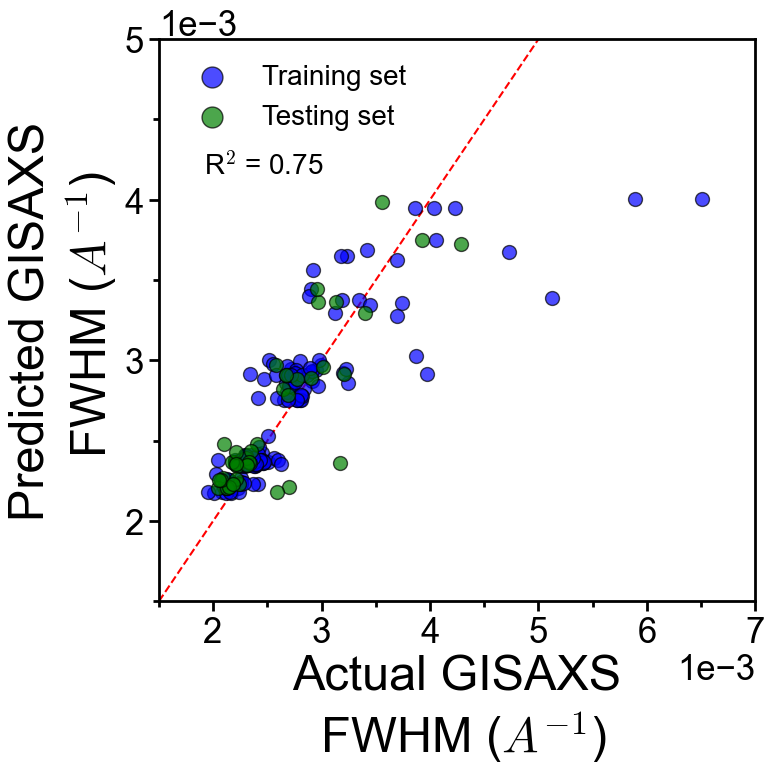

In [6]:
# Define the figure title
fig_title = f'{model_output}_avp_poster'
textstr = f'R$^2$ = {test_r2:.2f}'

%matplotlib inline
rc('text', usetex=False)
rc('mathtext', fontset='cm')
rc('xtick', labelsize=25)   
rc('xtick.major', size=7)  
rc('xtick.minor', size=4)
rc('xtick.major', width=2)
rc('xtick.minor', width=2)
rc('ytick.major', width=2)
rc('ytick.minor', width=2)
rc('ytick', labelsize=25)
rc('ytick.major', size=7)
rc('ytick.minor', size=4)
rc('axes', labelsize=25) 
rc('axes', linewidth=2) 
rc('font',family='sans serif')
rc('font', style='normal')
rc('font', weight='500')
rc('font', size='15')
rc('axes', labelweight='500')
rc('axes.spines', **{'right':True, 'top':True}) 
plt.rcParams['font.family'] = 'Arial'

#This sets the size of the entire image
fig,ax = plt.subplots(figsize=(8,8))
# Add a diagonal line for reference (perfect prediction)
plt.plot([0, 100], [0, 100], linestyle='--', color='red', zorder=0)
# Create a scatter plot
plt.scatter(y_train, rfr_train, color='blue', edgecolors='black', label='Training set', alpha=0.7, s=100)
plt.scatter(y_test, rfr_test, color='green', edgecolors='black', label='Testing set', alpha=0.7, s=100)

plt.tick_params(axis='both', which='both', reset=True, top=False, right=False)
#This sets the numerical distance between each major tick on the x axis
ax.xaxis.set_major_locator(MultipleLocator(.001))
#This sets the number of intervals between major ticks on the x axis
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
#This sets the numerical distance between each major tick on the y axis
ax.yaxis.set_major_locator(MultipleLocator(.001))
#This sets the number of intervals between major ticks on the x axis
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

# Add labels and a legend
plt.xlabel('Actual GISAXS\n FWHM ($A^{-1}$)', fontsize='35')
plt.ylabel('Predicted GISAXS\n FWHM ($A^{-1}$)', fontsize='35')

# Set legend background color to white
legend = plt.legend(fontsize=20, markerscale=1.5, frameon=False, loc='upper left')
legend.get_frame().set_facecolor('white')

# Set the background color to white
plt.gca().set_facecolor('white')

# Remove gridlines
plt.grid(False)

# Add tickmarks to x and y axes
plt.tick_params(axis='both', which='both', reset=True, top=False, right=False)

# # Add black borders to the grid
plt.gca().spines['top'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['right'].set_color('black')
plt.xlim(0.0015, 0.007)
plt.ylim(0.0015, 0.005)
plt.gca().ticklabel_format(axis='x', style='sci', scilimits=(0, 0)) 
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) 
# Show the plot
plt.tight_layout()
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=0)
# place a text box in upper left in axes coords
ax.text(0.075, 0.8, textstr, transform=ax.transAxes, fontsize=20,
        verticalalignment='top', bbox=props)

plt.savefig(output_path + fig_title, format='pdf')
plt.show()

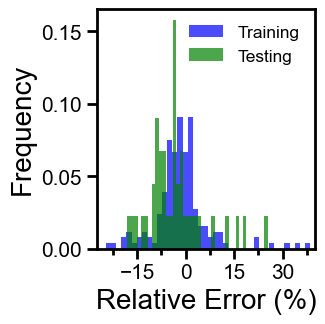

In [7]:
# Define the figure title
fig_title = f'{model_output}_relative_error_histogram'

# Calculate relative error as percent
rel_err_train_pct = 100 * (y_train - rfr_train) / y_train
rel_err_test_pct = 100 * (y_test - rfr_test) / y_test

# set formatting for plots
%matplotlib inline
rc('text', usetex=False)
rc('mathtext', fontset='cm')
rc('xtick', labelsize=15)  
rc('xtick.major', size=7)   
rc('xtick.minor', size=4)
rc('xtick.major', width=2)
rc('xtick.minor', width=2)
rc('ytick.major', width=2)
rc('ytick.minor', width=2)
rc('ytick', labelsize=15)
rc('ytick.major', size=7)
rc('ytick.minor', size=4)
rc('axes', labelsize=15) 
rc('axes', linewidth=2) 
rc('font',family='sans serif')
rc('font', style='normal')
rc('font', weight='500')
rc('font', size='15')
rc('axes', labelweight='500')
rc('axes.spines', **{'right':True, 'top':True})   
plt.rcParams['font.family'] = 'Arial'
# Create a histogram of relative errors
fig, ax = plt.subplots(figsize=(3.5, 3.5))

ax.xaxis.set_major_locator(MultipleLocator(15))
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
# ax.yaxis.set_major_locator(MultipleLocator(0.2))
# ax.yaxis.set_minor_locator(AutoMinorLocator(2))

bins = 40  # adjust as needed
plt.hist(rel_err_train_pct, bins=bins, alpha=0.7, color='blue', label='Training', density=True)
plt.hist(rel_err_test_pct, bins=bins, alpha=0.7, color='green', label='Testing', density=True)

plt.xlabel("Relative Error (%)", fontsize='20')
plt.ylabel("Frequency", fontsize='20')

# Set legend background color to white
legend = plt.legend(fontsize='12.5', frameon = False)
legend.get_frame().set_facecolor('white')

# Set the background color to white
plt.gca().set_facecolor('none')

# Remove gridlines
plt.grid(False)

# Add tickmarks to x and y axes
plt.tick_params(axis='both', which='both', reset=True, top=False, right=False)
plt.xlim(-27.5, 40)
# Add black borders to the plot
plt.gca().spines['top'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['right'].set_color('black')

plt.tight_layout()
plt.savefig(output_path + fig_title, format='pdf', transparent=True)
plt.show()

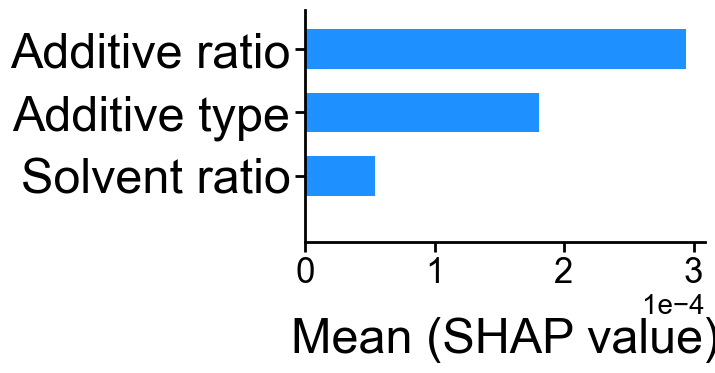

In [8]:
# Define the figure title
fig_title = 'shap/shap_global'
full_set = np.concatenate((X_train, X_test))

# Initialize the explainer with the model and the training data
explainer = shap.Explainer(best, X_train)
# Calculate SHAP values for the full set
shap_values = explainer.shap_values(full_set, check_additivity=False)

# Calculate average absolute SHAP values per feature
avg_shap_per_feature = np.abs(shap_values).mean(axis=0)

# Define feature names
features_r = ['Solvent ratio','Additive ratio', 'Additive type']

# Sort features by average SHAP value magnitude
sorted_indices = np.argsort(avg_shap_per_feature)[::-1]  # descending order
vg_shap_per_feature_r = avg_shap_per_feature[sorted_indices]
features_r_sorted = [features_r[i] for i in sorted_indices]

# Add dummy entry at the end
features_with_dummy = features_r_sorted + ['']
shap_values_with_dummy = list(vg_shap_per_feature_r) + [0]

# Define bar positions
spacing = 1.2
bar_positions = np.arange(len(features_with_dummy)) * spacing

# Set bar heights — last one is dummy, set its height independently
standard_height = 0.75
dummy_height = .05  # or whatever value you want
bar_heights = [standard_height] * (len(features_with_dummy) - 1) + [dummy_height]

# Plot
fig, ax = plt.subplots(figsize=(8, 4))

# Plot bars with individual heights
for pos, val, height in zip(bar_positions, shap_values_with_dummy, bar_heights):
    ax.barh(pos, val, height=height, color='dodgerblue')

# Customize y-axis — exclude dummy label and tick
ax.set_yticks(bar_positions[:-1])  # skip dummy
ax.set_yticklabels(features_with_dummy[:-1], fontsize=35)

# X-axis setup
ax.set_xlabel('Mean (SHAP value)', fontsize=35, labelpad=20)
# ax.set_xlim(0, 1)
ax.set_xticks(np.linspace(0, 0.0003, 4))
ax.tick_params(axis='x', labelsize=25)
ax.invert_yaxis()

# Clean styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust y-limits to account for dummy space
ax.set_ylim(bar_positions[-1] + dummy_height, bar_positions[0] - standard_height)
plt.gca().ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
ax.xaxis.offsetText.set_fontsize(20)
# Layout
plt.subplots_adjust(left=0.4, bottom=0.3)#, top=0.9)

plt.savefig(output_path + fig_title, format='pdf')
plt.show()

In [9]:
print(vg_shap_per_feature_r)

[2.94219825e-04 1.80442734e-04 5.36872109e-05]


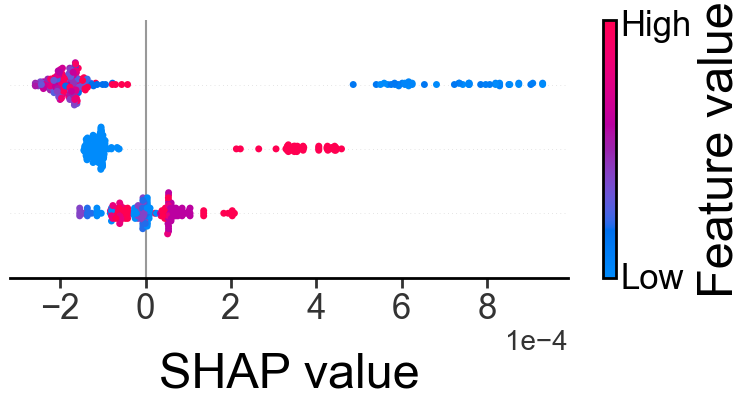

In [10]:
# Define the figure title
fig_title = 'shap/shap_local'
features_null = ['', '', '']

# Plot the SHAP values
shap_figure = shap.summary_plot(shap_values, full_set, feature_names=features_null, show=False, 
                                color_bar=False, plot_size=[8, 4])

# Get current axis
ax = plt.gca()

# Add and customize the colorbar
cbar = plt.colorbar()
cbar.set_label('Feature value', fontsize=35, wrap=True)
cbar.ax.tick_params(labelsize=25)

# Customize the colorbar ticks to show 'high' and 'low'
cbar.set_ticks([0.05, 0.95])
cbar.set_ticklabels(['Low', 'High'])
cbar.ax.tick_params(direction='out', length=0, width=0, grid_alpha=0.5)

# Set labels and ticks
plt.xlabel('SHAP value', fontsize=35, labelpad=20)
plt.xticks(fontsize=25)
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
ax.xaxis.offsetText.set_fontsize(20)

# Adjust layout
plt.subplots_adjust(bottom=0.3, right=0.9)
# plt.subplots_adjust(right=0.9)  # Move the right boundary in a bit

# Save the figure
plt.savefig(output_path + fig_title, format='pdf')
plt.show()

In [11]:
# Features ['Solvent ratio','Swelling ratio', 'Additive type']

# Remove the second column
swell_add_shap = np.delete(shap_values, 0, axis=1)
solv_add_shap = np.delete(shap_values, 1, axis=1)
solv_swell_shap = np.delete(shap_values, 2, axis=1)

In [12]:
# Features ['Solvent ratio','Swelling ratio', 'Additive type']

full_set_inv = xscaler.inverse_transform(full_set)

# Remove the second column
swell_add_x = np.delete(full_set_inv, 0, axis=1)
solv_add_x = np.delete(full_set_inv, 1, axis=1)
solv_swell_x = np.delete(full_set_inv, 2, axis=1)

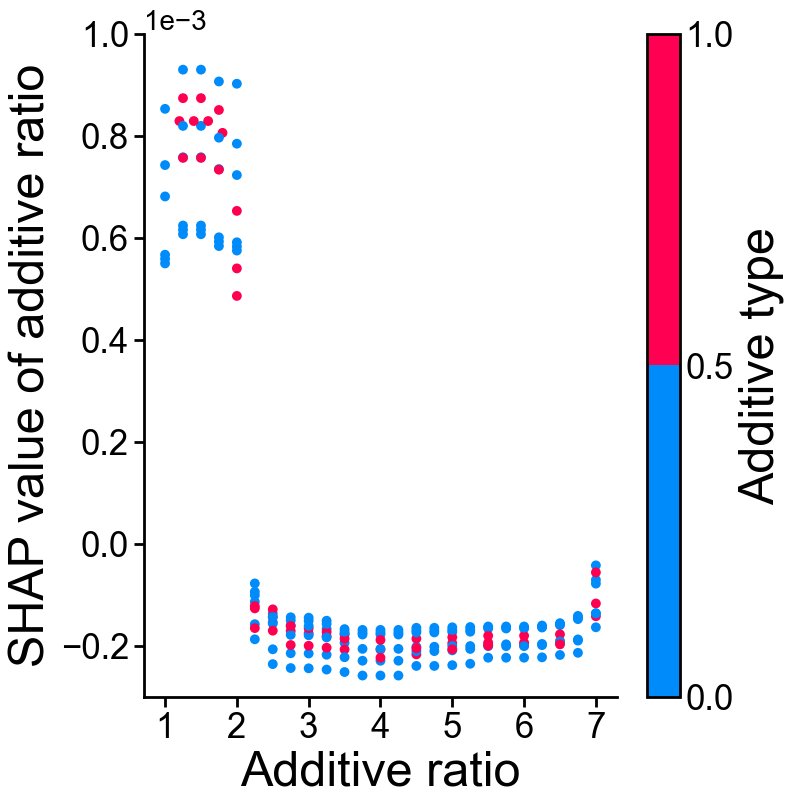

In [13]:
# Define the figure title
fig_title = 'shap/swell_add_shap'

features = ['Solvent ratio','Additive ratio', 'Additive type']
features = [features[1], features[2]]
feature_name = features[0]
# Plot the SHAP values
shap_figure = shap.dependence_plot(feature_name, swell_add_shap, swell_add_x, feature_names=features, show=False,
                                  dot_size=50)
plt.xlabel('Additive ratio', fontsize=35)
plt.ylabel('SHAP value of additive ratio', fontsize=35)
plt.tight_layout()
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
plt.ylim(-0.0003, 0.0010)
plt.gca().yaxis.offsetText.set_fontsize(20)
plt.savefig(output_path + fig_title, format='pdf')
# plt.tight_layout()
shap_figure

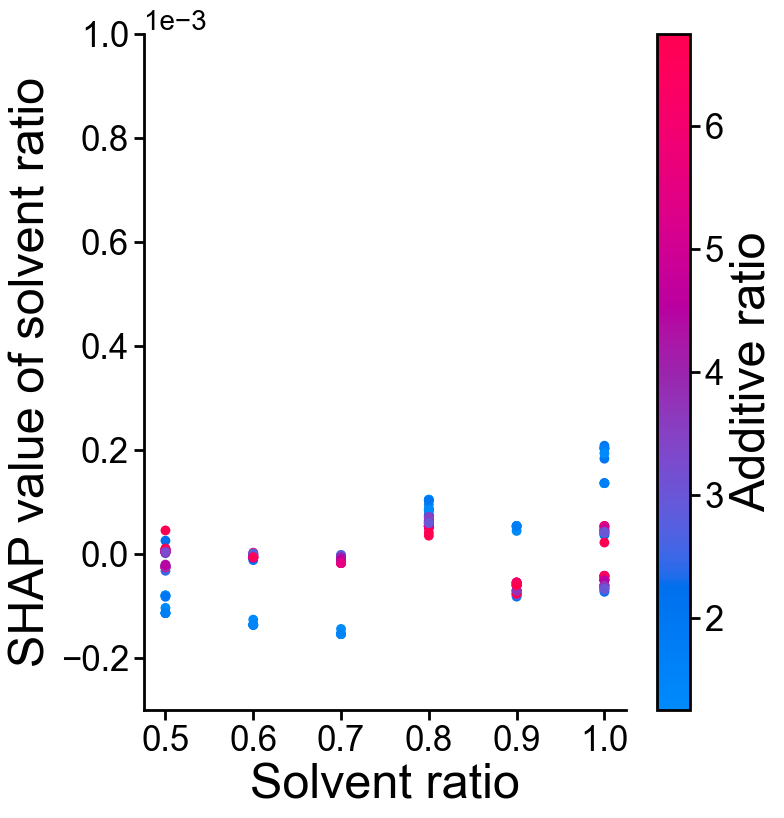

In [14]:
# Define the figure title
fig_title = 'shap/solv_swell_shap'

features = ['Solvent ratio','Additive ratio', 'Additive type']
features = [features[0], features[1]]
# print(features)
feature_name = features[0]
# Plot the SHAP values
shap_figure = shap.dependence_plot(feature_name, solv_swell_shap, solv_swell_x, feature_names=features, show=False,
                                  dot_size=50)
plt.xlabel('Solvent ratio', fontsize=35)
plt.ylabel('SHAP value of solvent ratio', fontsize=35, wrap=True)
plt.tight_layout()
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
plt.ylim(-0.0003, 0.0010)
plt.gca().yaxis.offsetText.set_fontsize(20)
plt.savefig(output_path + fig_title, format='pdf')
shap_figure

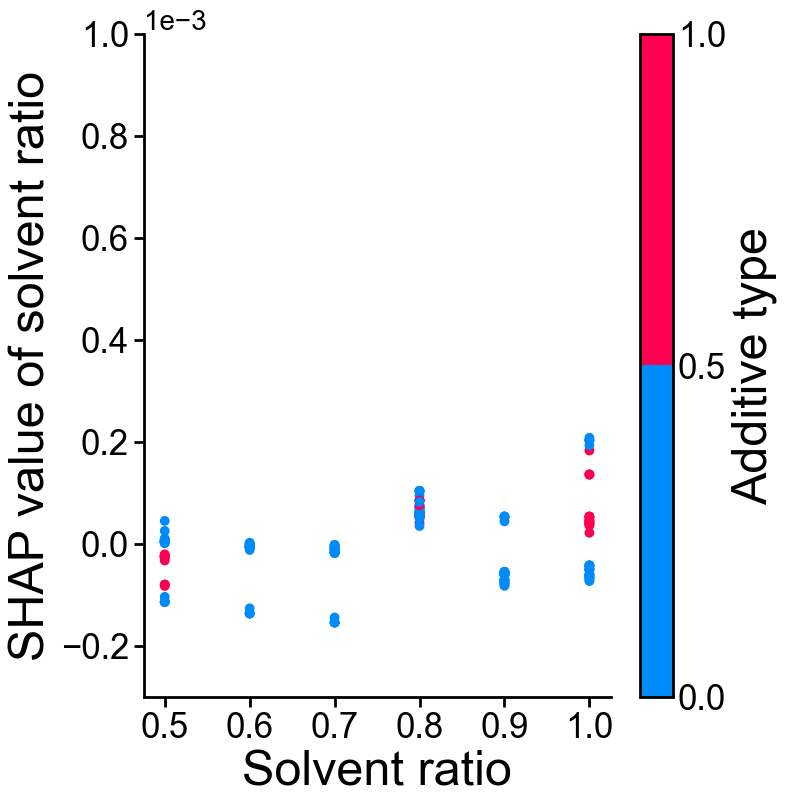

In [15]:
# Define the figure title
fig_title = 'shap/solv_add_shap'

features = ['Solvent ratio','Additive ratio', 'Additive type']
features = [features[0], features[2]]
# print(features)
feature_name = features[0]
# Plot the SHAP values
shap_figure = shap.dependence_plot(feature_name, solv_add_shap, solv_add_x, feature_names=features, show=False,
                                  dot_size=50)
plt.xlabel('Solvent ratio', fontsize=35)
plt.ylabel('SHAP value of solvent ratio', fontsize=35, wrap=True)
plt.tight_layout()
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
plt.ylim(-0.0003, 0.0010)
plt.gca().yaxis.offsetText.set_fontsize(20)
plt.savefig(output_path + fig_title, format='pdf')
shap_figure

# Switch collumns

In [16]:
# Creating a list of indices for reordering columns
i = [1, 0]

# Reorder the columns for new plots
add_swell_shap = swell_add_shap[:, i]
add_solv_shap = solv_add_shap[:, i]
swell_solv_shap = solv_swell_shap[:, i]

# Reorder the columns for new plots
add_swell_x = swell_add_x[:, i]
add_solv_x = solv_add_x[:, i]
swell_solv_x = solv_swell_x[:, i]

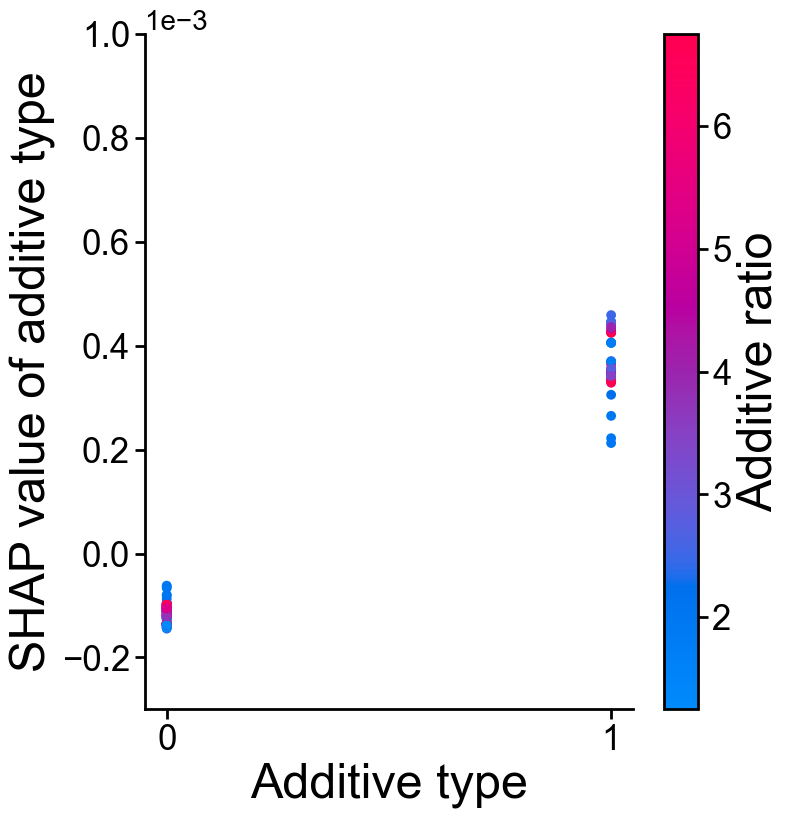

In [20]:
# Define the figure title
fig_title = 'shap/add_swell_shap'

features = ['Solvent ratio','Additive ratio', 'Additive type']
features = [features[2], features[1]]
# print(features)
feature_name = features[0]
# Plot the SHAP values
shap_figure = shap.dependence_plot(feature_name, add_swell_shap, add_swell_x, feature_names=features, show=False,
                                  dot_size=50)
plt.xlabel(feature_name, fontsize=35)
plt.ylabel('SHAP value of additive type', fontsize=35, wrap=True)
plt.tight_layout()
plt.xticks([0, 1], fontsize=25)  # <-- Only show ticks at 0 and 1
plt.yticks(fontsize = 25)
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
plt.ylim(-0.0003, 0.0010)
plt.gca().yaxis.offsetText.set_fontsize(20)
plt.savefig(output_path + fig_title, format='pdf')
shap_figure

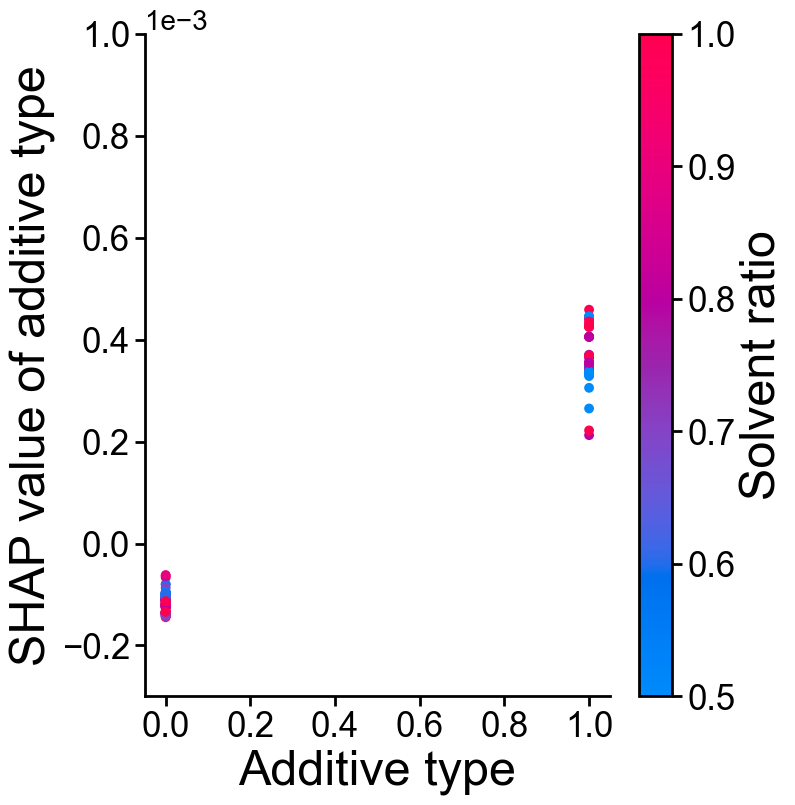

In [18]:
# Define the figure title
fig_title = 'shap/add_solv_shap'

features = ['Solvent ratio','Additive ratio', 'Additive type']
features = [features[2], features[0]]
# print(features)
feature_name = features[0]
# Plot the SHAP values
shap_figure = shap.dependence_plot(feature_name, add_solv_shap, add_solv_x, feature_names=features, show=False,
                                  dot_size=50)
plt.xlabel(feature_name, fontsize=35)
plt.ylabel('SHAP value of additive type', fontsize=35, wrap=True)
plt.tight_layout()
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
plt.ylim(-0.0003, 0.0010)
plt.gca().yaxis.offsetText.set_fontsize(20)
plt.savefig(output_path + fig_title, format='pdf')
shap_figure

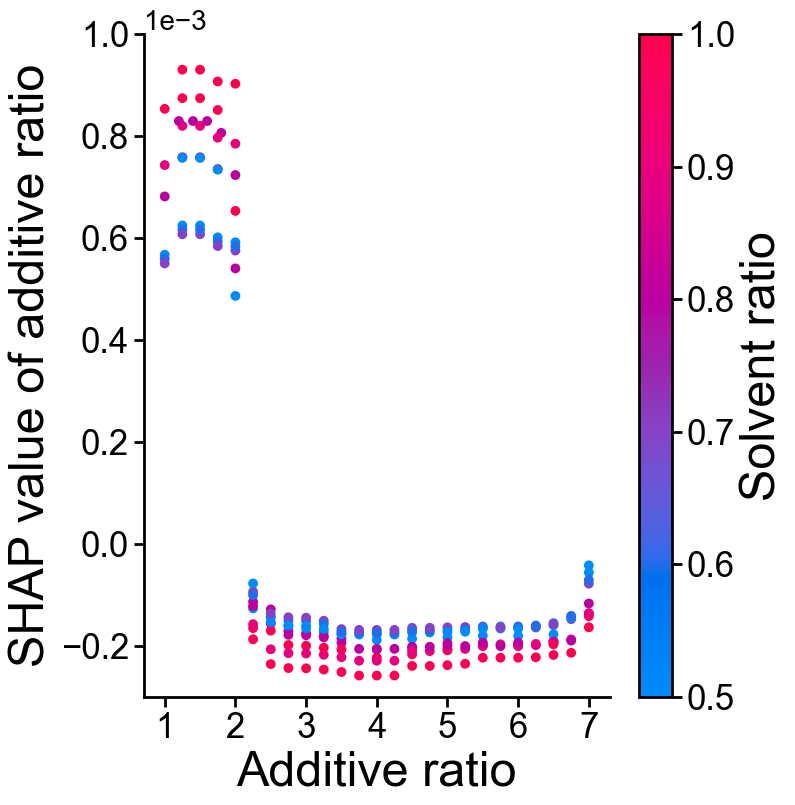

In [19]:
# Define the figure title
fig_title = 'shap/swell_solv_shap'

features = ['Solvent ratio','Additive ratio', 'Additive type']
features = [features[1], features[0]]
# print(features)
feature_name = features[0]
# Plot the SHAP values
shap_figure = shap.dependence_plot(feature_name, swell_solv_shap, swell_solv_x, feature_names=features, show=False,
                                  dot_size=50)
plt.xlabel(feature_name, fontsize=35)
plt.ylabel('SHAP value of additive ratio', fontsize=35, wrap=True)
plt.tight_layout()
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
plt.ylim(-0.0003, 0.0010)
plt.gca().yaxis.offsetText.set_fontsize(20)
plt.savefig(output_path + fig_title, format='pdf')
shap_figure